## Getting Lift Chart

**Author**: Matthew Cohen

**Label**: Evaluating Models

### Scope
The scope of this notebook is to provide instructions on how to retrieve the Lift Chart of a specific model using the Python API.

### Background
Insights provided by the Lift Chart are helpful in checking the performance of machine learning models. 

The lift chart depicts how well a model segments the target population and how capable it is of predicting the target across the prediction distribution.  This allows you to evaluate the performance of a model at both the high end (very likely) and low end (very unlikely) end of the spectrum. 

For example—so you can see how well the model performs for different ranges of values of the target variable. Looking at the Lift chart, the left side of the curve indicates where the model predicted a low score on one section of the population while the right side of the curve indicates where the model predicted a high score. In general, the steeper the actual line is, and the more closely the predicted line matches the actual line, the better the model is. A consistently increasing line is another good indicator.

### Requirements

- Python version 3.7.3
-  DataRobot API version 2.19.0. 
Small adjustments might be needed depending on the Python version and DataRobot API version you are using.

Full documentation of the Python package can be found here: https://datarobot-public-api-client.readthedocs-hosted.com/en/

It is assumed you already have a DataRobot <code>Project</code> object and a DataRobot <code>Model</code> object.

#### Import Libraries

In [4]:
import datarobot as dr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#Some color
dr_dark_blue = '#08233F'
dr_blue = '#1F77B4'
dr_orange = '#FF7F0E'
dr_red = '#BE3C28'

#### Requesting Lift Chart Data

Lift chart data can be retrieved for a specific data partition (validation, cross-validation, or holdout) using <code>get_lift_chart</code>. To retrieve the data for holdout partition, it needs to be unlocked first.

Let’s retrieve the validation partition data for top model using <code>get_lift_chart</code>. The <code>get_lift_chart</code> method returns data for validation partition by default. We can retrieve data for specific data partition by passing value to source parameter in <code>get_lift_chart</code>.

In [6]:
lc = model.get_lift_chart(source='validation')

#Saving to pandas dataframe
bins_df = pd.DataFrame(lc.bins)
bins_df.head()

,actual,bin_weight,predicted
0,0.037037,27.0,0.075109
1,0.074074,27.0,0.128871
2,0.153846,26.0,0.159114
3,0.222222,27.0,0.176280
4,0.185185,27.0,0.189534


Let’s define our rebinning and plotting functions.

In [7]:
def rebin_df(raw_df, number_of_bins):
    cols = ['bin', 'actual_mean', 'predicted_mean', 'bin_weight']
    new_df = pd.DataFrame(columns=cols)
    current_prediction_total = 0
    current_actual_total = 0
    current_row_total = 0
    x_index = 1
    bin_size = 60 / number_of_bins
    for rowId, data in raw_df.iterrows():
        current_prediction_total += data['predicted'] * data['bin_weight']
        current_actual_total += data['actual'] * data['bin_weight']
        current_row_total += data['bin_weight']

        if ((rowId + 1) % bin_size == 0):
            x_index += 1
            bin_properties = {
                'bin': ((round(rowId + 1) / 60) * number_of_bins),
                'actual_mean': current_actual_total / current_row_total,
                'predicted_mean': current_prediction_total / current_row_total,
                'bin_weight': current_row_total
            }

            new_df = new_df.append(bin_properties, ignore_index=True)
            current_prediction_total = 0
            current_actual_total = 0
            current_row_total = 0
    return new_df


def matplotlib_lift(bins_df, bin_count, ax):
    grouped = rebin_df(bins_df, bin_count)
    ax.plot(range(1, len(grouped) + 1), grouped['predicted_mean'],
            marker='+', lw=1, color=dr_blue)
    ax.plot(range(1, len(grouped) + 1), grouped['actual_mean'],
            marker='*', lw=1, color=dr_orange)
    ax.set_xlim([0, len(grouped) + 1])
    ax.set_facecolor(dr_dark_blue)
    ax.legend(loc='best')
    ax.set_title('Lift chart {} bins'.format(bin_count))
    ax.set_xlabel('Sorted Prediction')
    ax.set_ylabel('Value')
    return grouped

Now we can show all lift charts we propose in DataRobot web application.

- Note 1 : While this method will work for any bin count less then 60 - the most reliable result will be achieved when the number of bins is a divisor of 60.

- Note 2 : This visualization method will NOT work for bin count > 60 because DataRobot does not provide enough information for a larger resolution.

#### Plotting Lift Chart

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


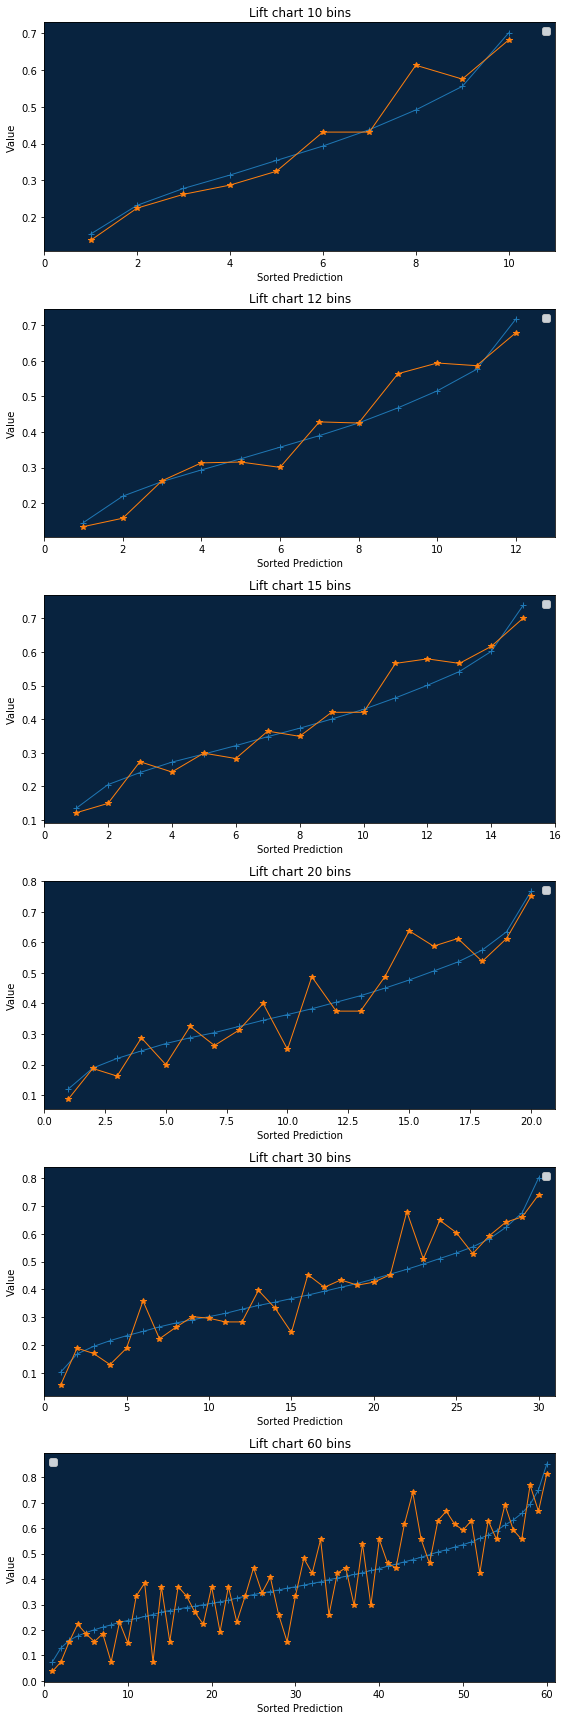

In [8]:
bin_counts = [10, 12, 15, 20, 30, 60]
f, axarr = plt.subplots(len(bin_counts))
f.set_size_inches((8, 4 * len(bin_counts)))

rebinned_dfs = []
for i in range(len(bin_counts)):
    rebinned_dfs.append(matplotlib_lift(bins_df, bin_counts[i], axarr[i]))
plt.tight_layout()